In [1]:
from technical import *
from backtest import *
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chart_studio import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, download_plotlyjs, iplot
init_notebook_mode(connected = True)
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-whitegrid")

In [2]:
msft = yf.Ticker("MSFT")
# get historical market data
hist = msft.history(period="max", start="2001-01-01", end="2020-07-17")

# Ichimoku Cloud Strategy

The Ichimoku Cloud concerns itself with two major elements - the signal and insights produced by the 'cloud' structure which is created by the interplay between the Senkou Span A and Senkou Span B and secondly the interplay between the price, the Kenkan-sen and the Kijun-sen. 

In [3]:
d = hist.copy()

In [4]:
d['tenkan_sen'], d['kijun_sen'], d['senkou_span_a'], d['senkou_span_b'], d['chikou_span'] = ichimoku_cloud(d.High, d.Low, d.Close)
d = d.dropna()

In [5]:
increasing_color = '#17BECF'
decreasing_color = '#7F7F7F'
data = [ dict(
    type = 'candlestick',
    open = d.Open,
    high = d.High,
    low = d.Low,
    close =d.Close,
    x = d.index,
    yaxis = 'y2',
    name = 'F',
    increasing = dict(line=dict(color=increasing_color)),
    decreasing = dict(line=dict(color=decreasing_color)))
    ]
layout = dict()
fig = dict(data=data, layout=layout)
fig['layout']['plot_bgcolor'] = 'rgb(250, 250, 250)'
fig['layout']['xaxis'] = dict(rangeselector=dict(visible=True))
fig['layout']['yaxis'] = dict(domain=[0, 0.2], showticklabels=False)
fig['layout']['yaxis2'] = dict(domain=[0.2, 0.8])
fig['layout']['legend'] = dict(orientation='h', y=0.9, x=0.3, yanchor='bottom')
fig['layout']['margin'] = dict(t=40, b=40, r=40, l=40)
rangeselector=dict(
    visible=True,
    x =0,
    y = 0.9,
    bgcolor = 'rgba(150, 200, 250, 0.4)',
    font = dict(size=13),
    buttons=list([
        dict(count=1,
            label='reset',
            step='all'),
        dict(count=1,
            label='1yr',
            step='year',
            stepmode='backward'),
        dict(count=1,
            label='3 mo',
            step='month',
            stepmode='backward'),
        dict(count=1,
            label='1 mo',
            step='month',
            stepmode='backward'),
        dict(step='all')
    ]))
fig['layout']['xaxis']['rangeselector'] = rangeselector
fig['data'].append(dict(x=d['tenkan_sen'].index, y=d['tenkan_sen'], type='scatter', mode='lines', line=dict(width=1), marker=dict(color='#33BDFF'), yaxis='y2', name='tenkan_sen'))
fig['data'].append(dict(x=d['kijun_sen'].index, y=d['kijun_sen'], type='scatter', mode='lines', line=dict(width=1), marker=dict(color='#F1F316'), yaxis='y2', name='tenkan_sen'))
fig['data'].append(dict(x=d['senkou_span_a'].index, y=d['senkou_span_a'], type='scatter', mode='lines', line=dict(width=1), marker=dict(color='#228B22'), yaxis='y2', name='tenkan_sen'))
fig['data'].append(dict(x=d['senkou_span_b'].index, y=d['senkou_span_b'], type='scatter', mode='lines', line=dict(width=1), fill='tonexty', marker=dict(color='#FF3342'), yaxis='y2', name='tenkan_sen'))
fig['data'].append(dict(x=d['chikou_span'].index, y=d['chikou_span'], type='scatter', mode='lines', line=dict(width=1), marker=dict(color='#D105F5'), yaxis='y2', name='tenkan_sen'))

colors = []
for i in range(len(d.Close)):
    if i != 0:
        if d.Close[i] > d.Close[i-1]:
            colors.append(increasing_color)
        else:
            colors.append(decreasing_color)
    else:
        colors.append(decreasing_color)

iplot(fig, filename="candlestick-ichimoku")

Buy when the following are true:
<br>
1) Prices are above the cloud 
<br>
2) Senkou Span A is above Senkou Span B 
<br>
EITHER ARE TRUE
<br>
3) Tenkan-sen crosses up through Kijun-sen
<br>
4) Pries cross up through the Tenkan-sen 
<br>
<br>
ELSE:
<br>
<br>
SELL

In [6]:
d.dropna(inplace=True)
d['above_cloud'] = 0 
d['above_cloud'] = np.where((d['Low'] > d['senkou_span_a']) & (d['Low'] > d['senkou_span_b']), 1, d['above_cloud'])
d['above_cloud'] = np.where((d['High'] < d['senkou_span_a']) & (d['High'] < d['senkou_span_b']), -1, d['above_cloud'])
d['A_abv_B'] = np.where((d['senkou_span_a'] > d['senkou_span_b']), 1, -1)
d['tenkan_kijun_cross'] = np.nan
d['tenkan_kijun_cross'] = np.where((d['tenkan_sen'].shift(1) <= d['kijun_sen'].shift(1)) & (d['tenkan_sen'] > d['kijun_sen']), 1, d['tenkan_kijun_cross'])
d['tenkan_kijun_cross'] = np.where((d['tenkan_sen'].shift(1) >= d['kijun_sen'].shift(1)) & (d['tenkan_sen'] < d['kijun_sen']), -1, d['tenkan_kijun_cross'])
d['price_tenkan_cross'] = np.nan
d['price_tenkan_cross'] = np.where((d['Open'].shift(1) <= d['tenkan_sen'].shift(1)) & (d['Open'] > d['tenkan_sen']), 1, d['price_tenkan_cross'])
d['price_tenkan_cross'] = np.where((d['Open'].shift(1) >= d['tenkan_sen'].shift(1)) & (d['Open'] < d['tenkan_sen']), -1, d['price_tenkan_cross'])
d['buy'] = np.nan
d['buy'] = np.where((d['above_cloud'].shift(1) == 1) & (d['A_abv_B'].shift(1) == 1) & ((d['tenkan_kijun_cross'].shift(1) == 1) | (d['price_tenkan_cross'].shift(1) == 1)), 1, d['buy'])
d['buy'] = np.where(d['tenkan_kijun_cross'].shift(1) == -1, 0, d['buy'])
d['buy'].ffill(inplace=True)
d['sell'] = np.nan
d['sell'] = np.where((d['above_cloud'].shift(1) == -1) & (d['A_abv_B'].shift(1) == -1) & ((d['tenkan_kijun_cross'].shift(1) == -1) | (d['price_tenkan_cross'].shift(1) == -1)), -1, d['sell'])
d['sell'] = np.where(d['tenkan_kijun_cross'].shift(1) == 1, 0, d['sell'])
d['sell'].ffill(inplace=True)
ichimoku_position = d['buy'] + d['sell']

# MACD + RSI Strategy 

The Moving Average Convergence Divergence (MACD) is a trend following momentum indicator that shows the relationship between two moving averages of a price. This strategy uses the MACD together with RSI which calculates whether a particular asset is overbouht or oversought in relation to recent price levels.

In [7]:
d = hist.copy()
d.sort_index(ascending=True, inplace=True)
d['macd'], d['macd_signal_line'] = macd(d.Close)
d['rsi'] = rsi(d.Close)
d = d.dropna()

Buy when the following are true:
<br>
1) MACD > MACD SIGNAL LINE 
<br>
2) RSI < 65
<br>
<br>
ELSE:
<br>
<br>
SELL

In [8]:
d['buy'] = np.nan
d['buy'] = np.where((d['macd'].shift(1) > d['macd_signal_line'].shift(1)) & (d['rsi'].shift(1) < 65), 1, d['buy'])
d['buy'] = np.where((d['rsi'].shift(1) > 50) & (d['macd'].shift(1) < d['macd_signal_line'].shift(1)), 0, d['buy'])
d['buy'].ffill(inplace=True)
d['sell'] = np.nan
d['sell'] = np.where((d['macd'].shift(1) < d['macd_signal_line'].shift(1)) & (d['rsi'].shift(1) > 35), -1, d['sell'])
d['sell'] = np.where((d['rsi'].shift(1) < 50) & (d['macd'].shift(1) > d['macd_signal_line'].shift(1)), 0, d['sell'])
d['sell'].ffill(inplace=True)
macd_position = d['buy'] + d['sell']

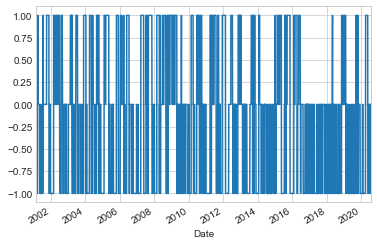

In [9]:
macd_position.plot()

# Comparing Strategies In Backtest

In [10]:
positions = dict()
positions['Ichimoku Cloud'] = ichimoku_position
positions['MACD-RSI'] = macd_position
# Backtest(Initial Price, Closing Price, "Start Date", "Period", "Positions Predicted by Strats")
# In Positions provided 1 indicates BUY and HOLD, any other position indicates SELL and hold in CASH
# Outputs All Strategies added + Dolllar Cost Average and Buy and Hold ( DEFAULT )
br = backtest(100000, d['Close'], "2020-03-15", 90, positions)

In [11]:
br.get_plot()

In [12]:
br.get_strat_stats("Ichimoku Cloud")

,Close,Signal,TotalUnitInvested,CashHeld,TotalInvestment,TotalValue,Gain/Loss
Date,,,,,,,
2020-03-16,135.04,0.0,740.521327,0.000000,100000.000000,100000.000000,0.000000
2020-03-17,146.16,0.0,0.000000,108234.597156,0.000000,108234.597156,8234.597156
2020-03-18,140.01,0.0,0.000000,108234.597156,0.000000,108234.597156,8234.597156
2020-03-19,142.31,0.0,0.000000,108234.597156,0.000000,108234.597156,8234.597156
2020-03-20,136.97,0.0,0.000000,108234.597156,0.000000,108234.597156,8234.597156
2020-03-23,135.60,0.0,0.000000,108234.597156,0.000000,108234.597156,8234.597156
2020-03-24,147.93,0.0,0.000000,108234.597156,0.000000,108234.597156,8234.597156
2020-03-25,146.51,0.0,0.000000,108234.597156,0.000000,108234.597156,8234.597156
2020-03-26,155.68,0.0,0.000000,108234.597156,0.000000,108234.597156,8234.597156
